<a href="https://colab.research.google.com/github/yalexie1/Data-Science/blob/main/Unit7/YaleXie_Unit7Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Introduction

For my Unit 7 project, I will be creating multiple models with multiple predictors to predict **Walmart's yearly stock price change** from three factors: **MKT, SMB, and HML**.

The models I will create are the following:
1. Single-predictor linear
2. Single-predictor polynomial
3. Single-predictor b-spline
4. Multiple-predictor linear (with one interaction)
5. Polynomial b-spline

**Extra Information:**

The three factors I just mentioned (MKT, SMB, HML) are actually previously defined factors for stock returns from Eugene Fama and Kenneth French's groundbreaking finance paper Common Risk Factors in the Returns of Stocks and Bonds (1992). This paper introduced two additional factors to the original Capital Asset Pricing Model (CAPM), which only had one factor: MKT, or the excess return of a general market portfolio over the risk-free rate. SMB stands for "Small Minus Big" and it describes the excess returns of small-cap stocks over large-cap stocks. HML stands for "High Minus Low" and it describes the excess returns of high book-to-market equity ratio stocks to low book-to-market equity ratio stocks. Together, they account for approximately 90-95% of a stock's expected returns. The Fama-French Three-Factor Model is a robust way of checking portfolios are being well managed: a significant positive alpha (returns unexplained by the three factors) indicates that the portfolio manager is performing well.

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

# Part II: Data

The data I am using comes from **Kenneth French's website** and the **MacroTrends website**. Let's upload the data by reading the csv file I created by combining the data from the two websites.

** Ignore RMW and CMA (they are the two additional factors Fama and French added when they introduced their Five-Factor model, which I won't be using in this project).

In [3]:
ff_data = pd.read_csv("https://raw.githubusercontent.com/xeqoir/Data-Science/refs/heads/main/Unit7/Unit%207%20Data%20-%20Sheet1.csv")
ff_data.head(5)

,Year,MKT,SMB,HML,RMW,CMA,Change
0,1973,-26.18,-23.51,17.47,-8.76,7.18,-61.48
1,1974,-35.75,-0.81,9.96,-4.43,22.74,-28.85
2,1975,32.44,15.41,9.14,0.92,0.40,178.38
3,1976,21.91,14.67,24.38,-6.53,7.42,17.48
4,1977,-8.26,22.62,7.46,2.43,-0.01,30.58


In [4]:
print(ff_data.MKT.max())
print(ff_data.MKT.min())
print(ff_data.MKT.mean())
print(ff_data.SMB.mean())
print(ff_data.HML.mean())

35.2
-38.34
8.113673469387756
2.1204081632653056
3.7361224489795917


Short *finance* aside: The fact that MKT, SMB, and HML are all positive on average indicates that Fama and French's factors are working as expected. Each of these factors are the **excess return** of a portfolio of a certain type over another (general market portfolio over risk-free portfolio, small cap portfolio over big cap portfolio, high BE-ratio portfolio over low BE-ratio portfolio). These excess returns should be **positive**, which is what we have observed here.

# Part III: Models

Again, here are the models I will be creating for this project:
1. Single-predictor linear
2. Single-predictor polynomial
3. Single-predictor b-spline
4. Multiple-predictor linear (with one interaction)
5. Polynomial b-spline

## Linear MKT Model

In [ ]:
model1 = bmb.Model("Change ~ MKT", ff_data)
idata1 = model1.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


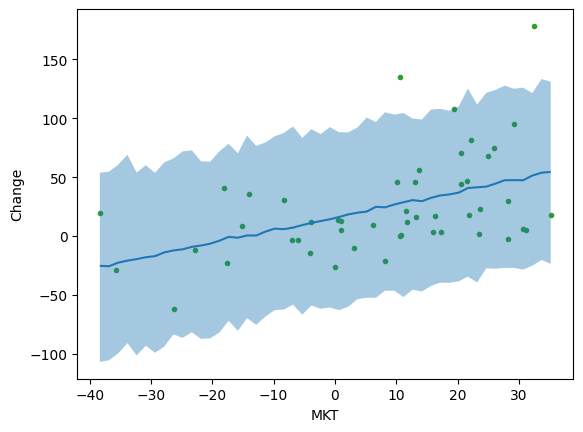

In [6]:
bmb.interpret.plot_predictions(model1, idata1, "MKT", pps=True)
plt.plot(ff_data.MKT, ff_data.Change, "C2.", zorder=-3)

Captures the **general upward trend** of the change in stock price vs. MKT factor. This is **accurate** and **consistent with reality**, since a higher MKT factor generally means the economy is good (the overall market's return is higher than a treasury bond's return).

However, this first degree linear model lacks depth and a lot of the company specific data is not modeled well.

## Polynomial MKT Model

In [ ]:
model2 = bmb.Model("Change ~ poly(MKT, degree = 4)", ff_data)
idata2 = model2.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


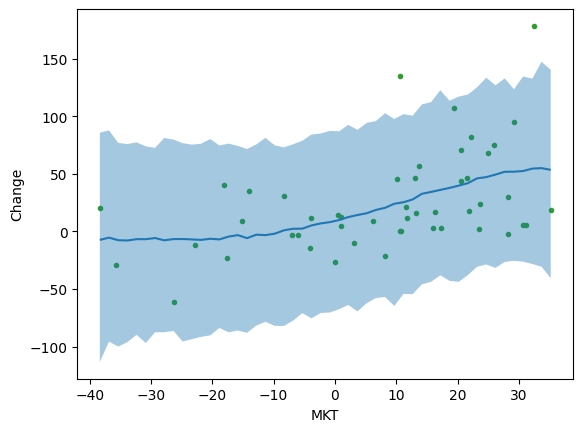

In [8]:
bmb.interpret.plot_predictions(model2, idata2, "MKT", pps=True)
plt.plot(ff_data.MKT, ff_data.Change, "C2.", zorder=-3)

Stills captures the correct trend between change in stock price and MKT factor. **Slightly more nuanced** and begins to curve in the direction of company-specific data.

However, it's still very rudimentary and most of the data points are not well modeled.

## B-spline MKT Model

In [ ]:
num_knots = 6
knots = np.linspace(-38, 35, num_knots + 2)[1:-1]
model3 = bmb.Model("Change ~ bs(MKT, degree = 4, knots = knots)", ff_data)
idata3 = model3.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


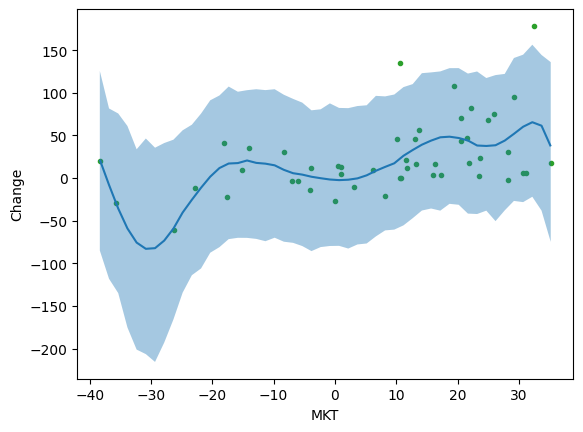

In [10]:
bmb.interpret.plot_predictions(model3, idata3, "MKT", pps=True)
plt.plot(ff_data.MKT, ff_data.Change, "C2.", zorder=-3)

**Excellent modeling** compared to the two previous models. It still shows a general upwards trend (a little less obvious now) between change in stock price and MKT factor, but it's much more **company-specific** now. It models the nuances within the data and it's the best one we have so far.

## Multiple Linear Three-Factor Model

In [ ]:
model4 = bmb.Model("Change ~ MKT + SMB + HML + SMB : HML", data=ff_data)
idata4 = model4.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='SMB', ylabel='Change'>], dtype=object))

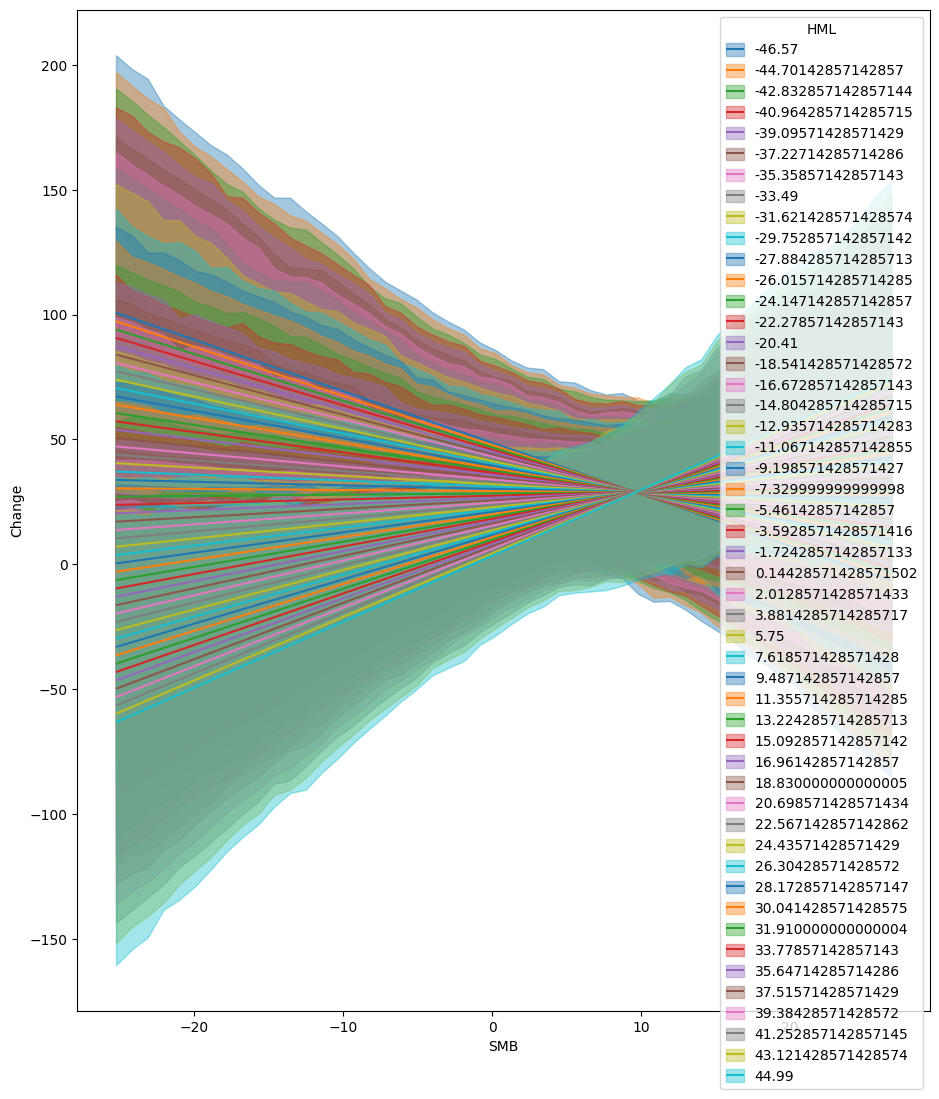

In [12]:
bmb.interpret.plot_predictions(model4,
                               idata4,
                               ["SMB","HML"],
                               fig_kwargs={"figsize":(11, 13)})

This model was the best one from my **last project**. I'll explain this model briefly: since SMB and HML are both relatively affected by public sentiment (that is ultimately what determines market cap and BME ratio), it makes sense that connecting these two factors would perhaps work in favor of the model.

## Polynomial B-Spline Model

In [ ]:
knots_MKT = [-20, -5, 0, 5, 10, 20, 30]
knots_SMB = [-15, -10, -5, 0, 5, 10, 15]
knots_HML = [-15, -10, -5, 0, 5, 10, 15]
model5 = bmb.Model("Change ~ bs(MKT, degree = 4, knots = knots_MKT) + bs(SMB, degree = 4, knots = knots_SMB) + bs(HML, degree = 4, knots = knots_HML)", data = ff_data)
idata5 = model5.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


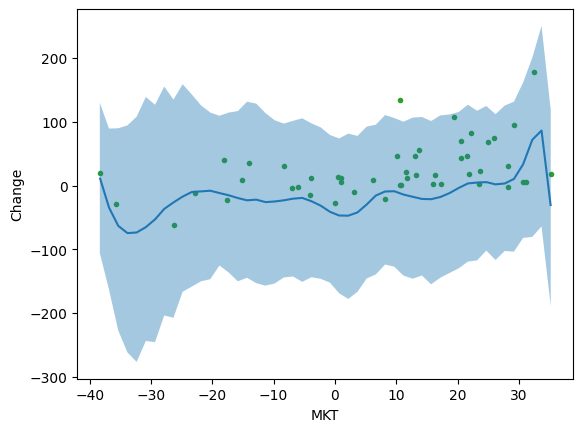

In [14]:
bmb.interpret.plot_predictions(model5, idata5, "MKT", pps=True)
plt.plot(ff_data.MKT, ff_data.Change, "C2.", zorder=-3)

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


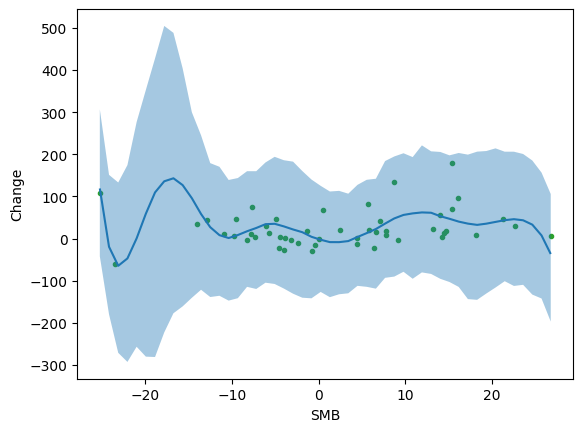

In [15]:
bmb.interpret.plot_predictions(model5, idata5, "SMB", pps=True)
plt.plot(ff_data.SMB, ff_data.Change, "C2.", zorder=-3)

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


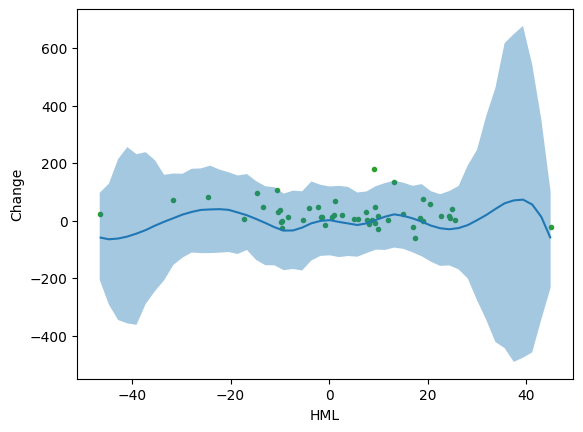

In [16]:
bmb.interpret.plot_predictions(model5, idata5, "HML", pps=True)
plt.plot(ff_data.HML, ff_data.Change, "C2.", zorder=-3)

This is a very interesting model in that it models change in stock price vs. MKT **less well than our original** single-predictor b-spline, but also happens to model change in stock price vs. SMB and change in stock price vs. HML **pretty well**. The biggest issue isn't necessarily with the model, but with the **lack of data at the ends of each factor's data**. This missing data is hard to predict, hence the huge range of possible data (shaded blue area).

A quick note on the placement of the knots: I chose them manually based on where I thought there was the **most activity** in data (looking at a scatterplot).

# Part IV: Final Results

**Initial Predictions (before elpd_loo)**

The best model we have for **Change vs MKT** is the single-predictor b-spline.

The best model we have for **Change vs SMB** is the multiple-predictor b-spline.

The best model we have for **Change vs. HML** is the multiple-predictor b-spline.

I think the best out of all of these is the first one, mainly because it actually models reality accurately (the trend is clearly shown and correct). The other two (SMB and HML) are still alright, but their lack of end data is a huge shortcoming and it makes the model's trend more ambiguous when it really shouldn't be.

In [ ]:
cmp = az.compare({"1": idata1,"2": idata2, "3": idata3, "4": idata4, "5": idata5})

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

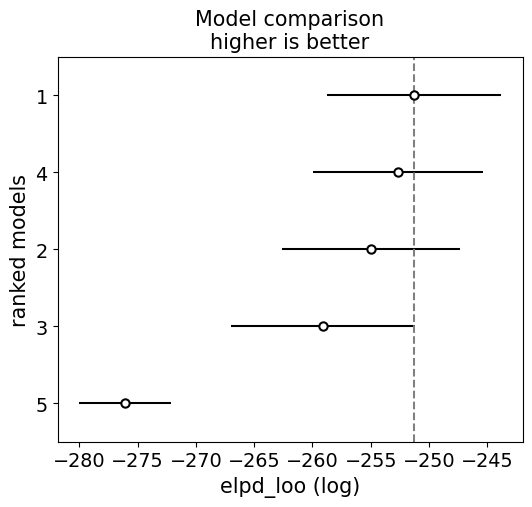

In [18]:
az.plot_compare(cmp)

**elpd_loo Results**

After analyzing the elpd_loo, it tells me that my initial model is in fact the best, which is not what I was expecting. It also tells me my final model (polynomial b-spline) is very bad compared to the rest of the models. The best way I can think of to explain this is that the elpd_loo test didn't like how the b-spline models fitted the data (which obfuscated the upwards trend for Change vs. MKT). This could be alternatively be explained as overfitting.

## Final Comments:

After the elpd_loo tests and after analyzing trends in reality, I've come to a conclusion on which model is best: Model 1 (linear MKT). My reasoning is that Change vs MKT factor is *supposed* to be positive linear (Fama-French formula) and it makes sense that it is positive linear (the better the market is, the better all stocks generally perform). Model 1 accurately demonstrates this fact: the fluctuations within the increases are not really meaningful to our analysis, ESPECIALLY WHEN EXTRAPOLATED TO OTHER STOCKS OR THE OVERALL MARKET, which is what I wanted to do in the first place (take a small example and make conclusions about market in general).